# Example 6-2: Filtering application to free vibration

This example shows an application of filtering.

<img src="./figures/Fig_4_1.svg">

Let us use the structure from example 4.1 to demonstrate.

We apply a slow ramp-up force to the top floor, before the the structure is released into free vibration.


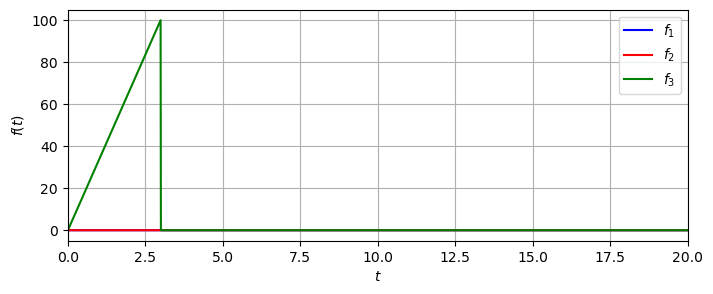

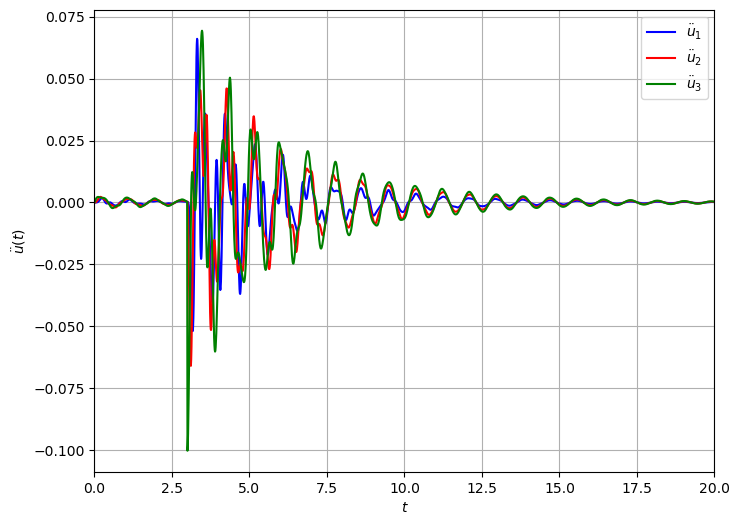

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as sps
from functions import sDynFunctions

# Structural properties
m = 1000.0; 
c = 2000.0;
EI = 2.1E11*3.36E-6;
L = 4.0;
k = 2*12*EI/L**3;
MM = np.diag([1, 1, 1])*m;
KK = np.array([ [2, -1, 0], [-1, 2, -1], [0, -1, 1]])*k
CC = np.diag([1, 0.5, 0])*c;

dt=0.01 # Time step
T=20 # Total time
t = np.arange(0,T,dt) # Time vector

f=np.zeros((3,len(t))) # Force vector

t_ramp = np.arange(0,3,dt) # Time vector ramp-up
f[2,np.arange(0,len(t_ramp))]=np.linspace(0,100,len(t_ramp)) # Apply to DOF 3

# Plot force
plt.figure(figsize=(8,3))   
plt.plot(t,f[0,:],color='b',label='$f_1$')  
plt.plot(t,f[1,:],color='r',label='$f_2$')    
plt.plot(t,f[2,:],color='g',label='$f_3$')
plt.xlabel('$t$')
plt.ylabel('$f(t)$');
plt.xlim(0,20)
plt.grid()
plt.legend()

u0=np.zeros((3,1)) # Initial displacement
udot0=np.zeros((3,1)) # Initial velocity

# Newmark time integration
u, udot, u2dot=sDynFunctions.linear_newmark_krenk(MM,CC,KK,f,u0,udot0,dt,0.5,0.25)
    
# Plot displacements
plt.figure(figsize=(8,6))   
plt.plot(t,u2dot[0,:],color='b',label='$\ddot{u}_1$')  
plt.plot(t,u2dot[1,:],color='r',label='$\ddot{u}_2$')    
plt.plot(t,u2dot[2,:],color='g',label='$\ddot{u}_3$')    
plt.xlabel('$t$')
plt.ylabel('$\ddot{u}(t)$');
plt.xlim(0,20)
plt.grid()
plt.legend()


The acceleration response decays to zero as expected. However, if we want to estimate the modal damping ratio it is difficult since there appear to be multiple modes decaying at the same time. 

We plot a Fourier transform of the signal to confirm this.

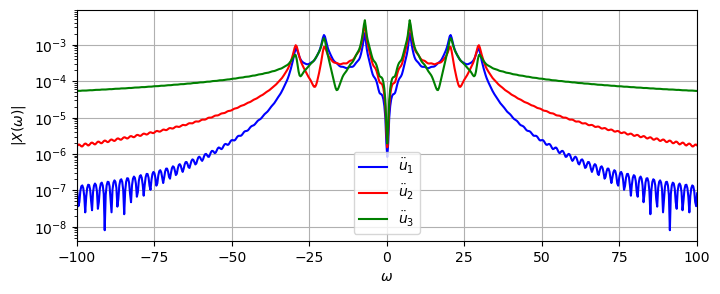

In [74]:
u2dot_fft = np.fft.fftshift(np.fft.fft(u2dot,axis=1),axes=1)/t.shape[0] # Fourier coefficients by fft
Npoints = t.shape[0] # Npoints in the time series 
fs = 1.0/(t[1]-t[0]) # Sampling frequency
f = np.linspace(-fs/2,fs/2,Npoints) # Frequency axis. From negative to positive Nyquist frequency
w = 2*np.pi*f # Frequency in rad/s
# Plot Fourier amplitudes.

plt.figure(figsize=(8,3))
plt.plot(w,np.abs(u2dot_fft[0,:]),color='b',label='$\ddot{u}_1$')
plt.plot(w,np.abs(u2dot_fft[1,:]),color='r',label='$\ddot{u}_2$')
plt.plot(w,np.abs(u2dot_fft[2,:]),color='g',label='$\ddot{u}_3$')
plt.xlim(-100,100)

plt.ylabel(r'$|X(\omega)|$')
plt.xlabel(r'$\omega$')
plt.legend()
plt.yscale('log')
plt.grid()



There are 3 peaks corresponding to natural frequency of each of the 3 modes.

We can filter out the contribution from the 2 highest modes with a low-pass Butterworth  filter. We set the cut-off frequency to 2 Hz and the filter order to 8.


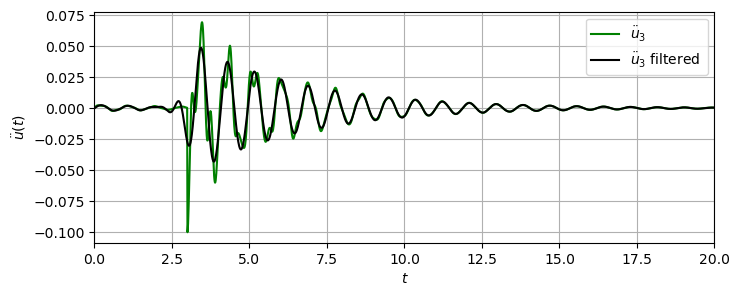

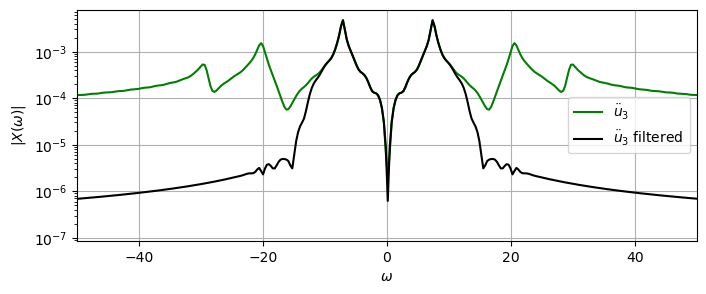

In [76]:
from scipy import signal as spsp

# Design filter
filter_order = 8 
cutoff_frequency = 2
sampling_frequency = 1/(t[1]-t[0])
b, a = spsp.butter(filter_order,cutoff_frequency, analog=True) #Obtain the filter coefficients
circular_frequency, frequency_response = spsp.freqs(b,a,worN = 1000)

# Filter acceleration time series
sos = spsp.butter(filter_order,cutoff_frequency,"low", fs=sampling_frequency, output='sos')
u2dot_filt = spsp.sosfiltfilt(sos, u2dot)

# Plot original and filtered time series
plt.figure(figsize=(8,3))
plt.plot(t, u2dot[2,:],color='g',label='$\ddot{u}_3$')
plt.plot(t,u2dot_filt[2,:],color='k',label='$\ddot{u}_3$ filtered ')
plt.xlim(0,20)
plt.xlabel(r"$t$")
plt.ylabel("$\ddot{u}(t)$")
plt.grid()
plt.legend()
plt.show()

# Plot Fourier transform of original and filtered data
u2dot_filt_fft = np.fft.fftshift(np.fft.fft(u2dot_filt,axis=1),axes=1)/t.shape[0] # Fourier coefficients by fft

plt.figure(figsize=(8,3))
plt.plot(w,np.abs(u2dot_fft[2,:]),color='g',label='$\ddot{u}_3$')
plt.plot(w,np.abs(u2dot_filt_fft[2,:]),color='k',label='$\ddot{u}_3$ filtered ')

plt.xlim(-50,50)
plt.ylabel(r'$|X(\omega)|$')
plt.xlabel(r'$\omega$')
plt.legend()
plt.yscale('log')
plt.grid()


We see that the filtered signal is a clean decaying cosine with only contribution from the first mode. This time series can be used to estimate the damping in mode 1 using logarithmic decrement.